# Выбор локации для скважины

**Описание исследования**

Компания «ГлавРосГосНефть» предоставила пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерено качество нефти и объём её запасов.

**Цель исследования**

Выбрать в каком регионе бурить новую скважину.

**Задачи исследования**

- Построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль.
- Проанализировать возможную прибыль и риски техникой Bootstrap.

**Описание данных**

Данные геологоразведки трёх регионов находятся в трех разных CSV-файлах, где столбцы:
- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек;
- product — объём запасов в скважине (тыс. баррелей).

In [1]:
#загрузка библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

!pip install phik -q
import phik
from phik.report import plot_correlation_matrix

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

RANDOM_STATE = 42
TEST_SIZE = 0.25

## Загрузка и подготовка данных

In [2]:
try:
    geo_0 = pd.read_csv('geo_data_0.csv')
    geo_1 = pd.read_csv('geo_data_1.csv')
    geo_2 = pd.read_csv('geo_data_2.csv')
except:
    geo_0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
    geo_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
    geo_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')

In [3]:
geo_0.info()
geo_0.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [4]:
geo_1.info()
geo_1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [5]:
geo_2.info()
geo_2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Можем видеть, что пропущенных значений нету, также все параметры имеют правильные типы данных.

Столбец `id` во всех трех таблицах не несет полезной информации, перенесем его значения в индексы.

In [6]:
geo_0 = geo_0.set_index('id')
geo_1 = geo_1.set_index('id')
geo_2 = geo_2.set_index('id')

Далее проверим наличие дубликатов в таблицах:

In [7]:
print('дубликаты в geo_0:', geo_0[geo_0.duplicated()].shape[0])
print('дубликаты в geo_1:', geo_1[geo_1.duplicated()].shape[0])
print('дубликаты в geo_2:', geo_2[geo_2.duplicated()].shape[0])

дубликаты в geo_0: 0
дубликаты в geo_1: 0
дубликаты в geo_2: 0


В данных отстутствуют дублирующие позиции.

In [8]:
print('Нулевые значения объема нефти в скважинах в geo_0:', geo_0.query('product == 0').shape[0])
print('Нулевые значения объема нефти в скважинах в geo_1:', geo_1.query('product == 0').shape[0])
print('Нулевые значения объема нефти в скважинах в geo_2:', geo_2.query('product == 0').shape[0])

Нулевые значения объема нефти в скважинах в geo_0: 1
Нулевые значения объема нефти в скважинах в geo_1: 8235
Нулевые значения объема нефти в скважинах в geo_2: 1


Скважины из второго региона имеют много нулевых значений объема нефти. Первая и третья на нее фоне выглядит слишком оптимистичными, во всех месторождениях, кроме одного, была найдена нефть.

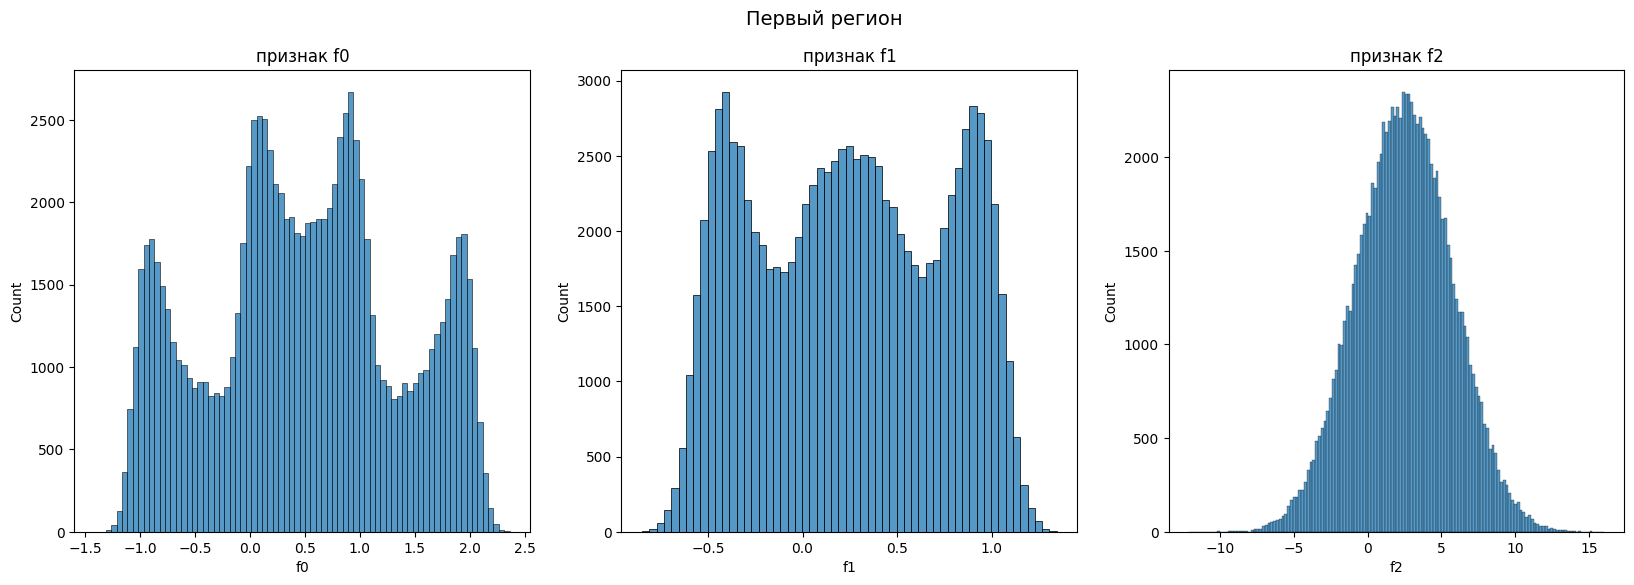

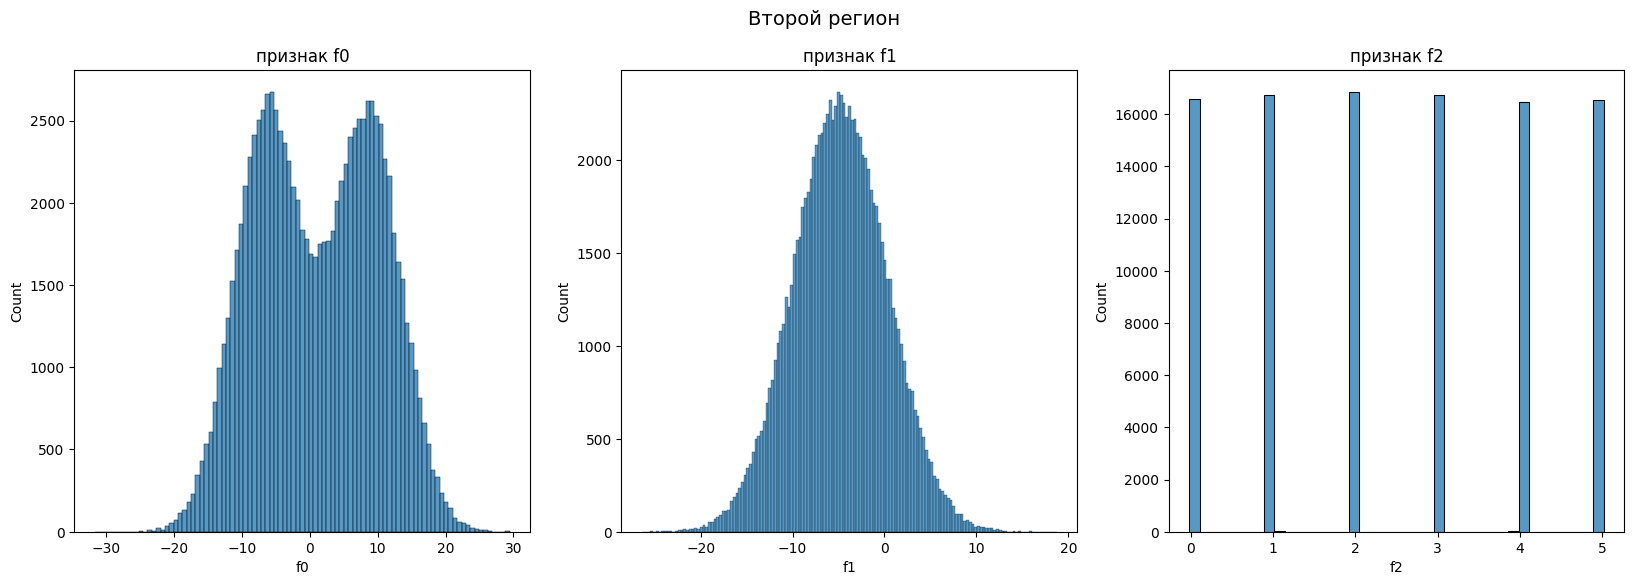

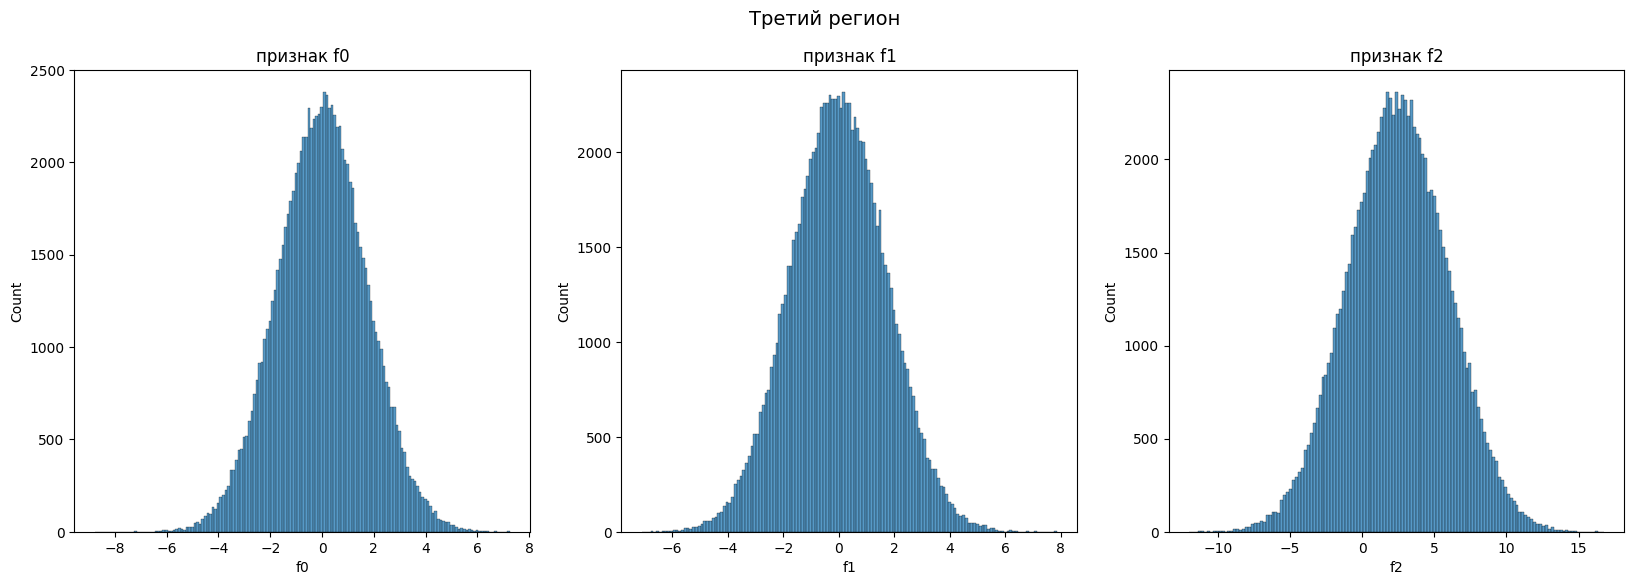

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,6))
fig.suptitle('Первый регион', fontsize=14)
sns.histplot(geo_0['f0'], ax=axes[0]).set_title('признак f0')
sns.histplot(geo_0['f1'], ax=axes[1]).set_title('признак f1')
sns.histplot(geo_0['f2'], ax=axes[2]).set_title('признак f2')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,6))
fig.suptitle('Второй регион', fontsize=14)
sns.histplot(geo_1['f0'], ax=axes[0]).set_title('признак f0')
sns.histplot(geo_1['f1'], ax=axes[1]).set_title('признак f1')
sns.histplot(geo_1['f2'], ax=axes[2]).set_title('признак f2')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,6))
fig.suptitle('Третий регион', fontsize=14)
sns.histplot(geo_2['f0'], ax=axes[0]).set_title('признак f0')
sns.histplot(geo_2['f1'], ax=axes[1]).set_title('признак f1')
sns.histplot(geo_2['f2'], ax=axes[2]).set_title('признак f2');

Признак f2 для второго региона имеет довольно странные значения, лежащие около чисел 0,1,2,3,4,5. Для второго и третьего регионов признак f2 имеет нормальное распределение.

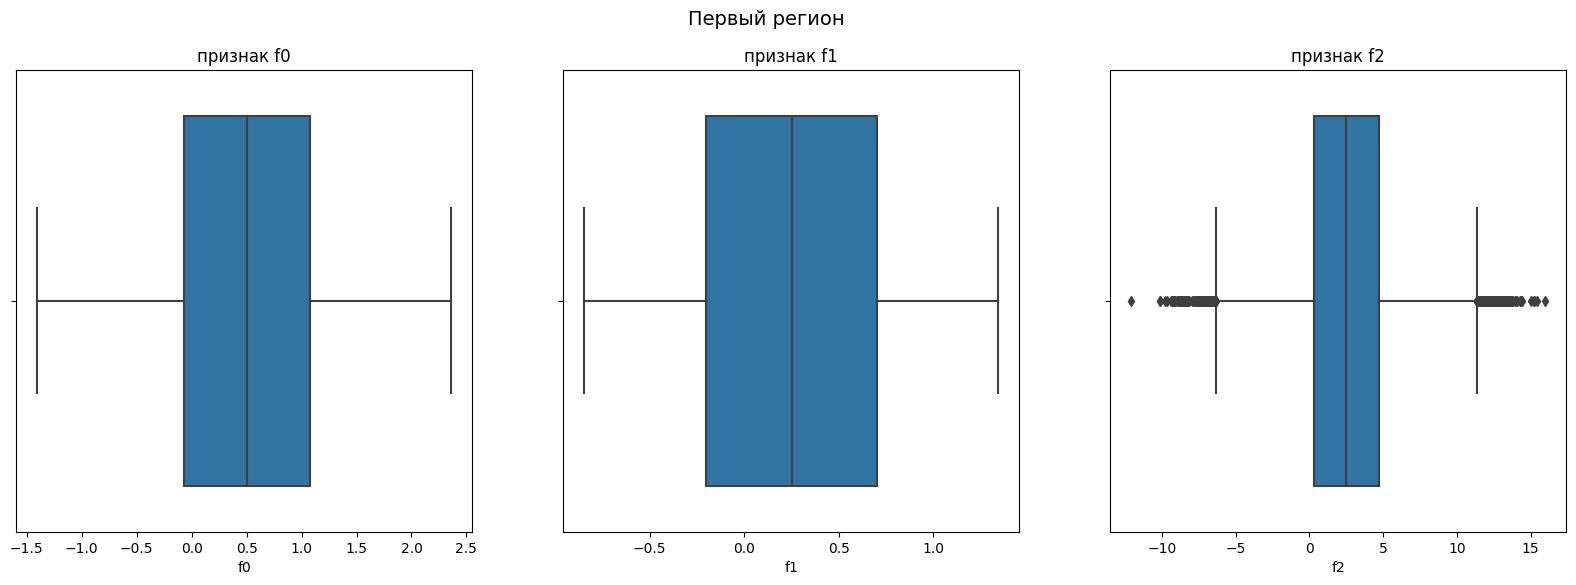

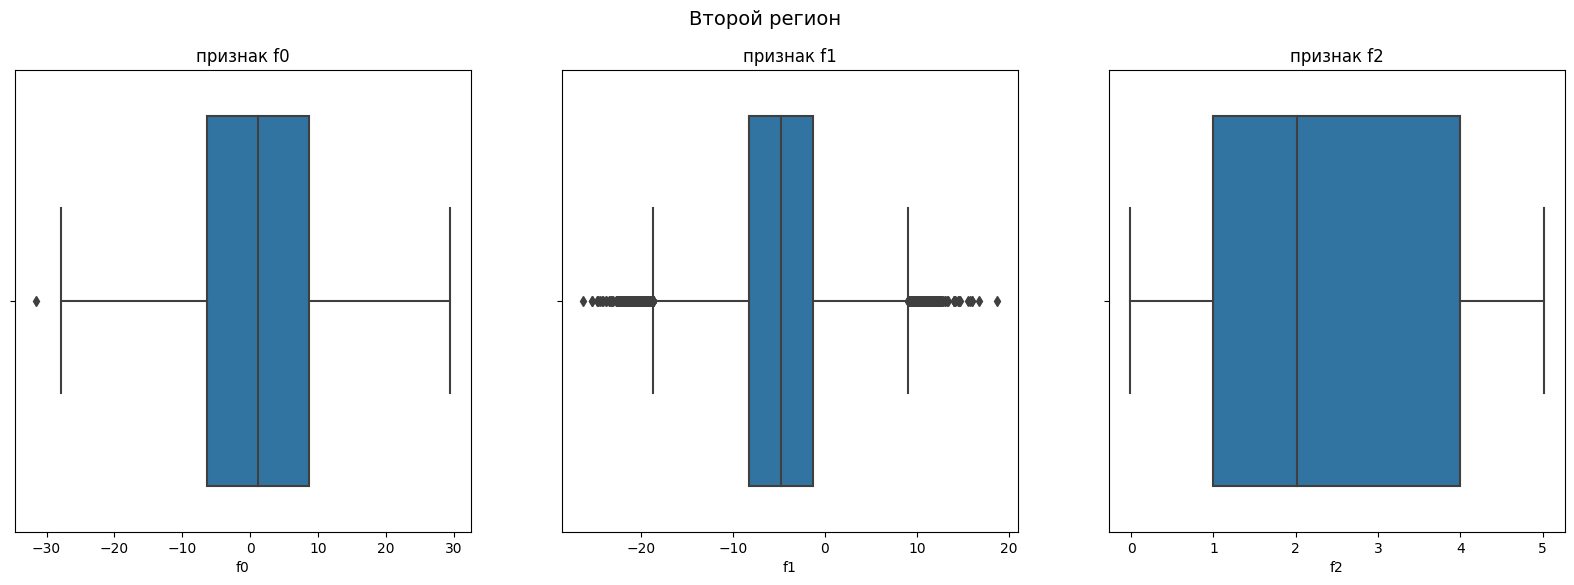

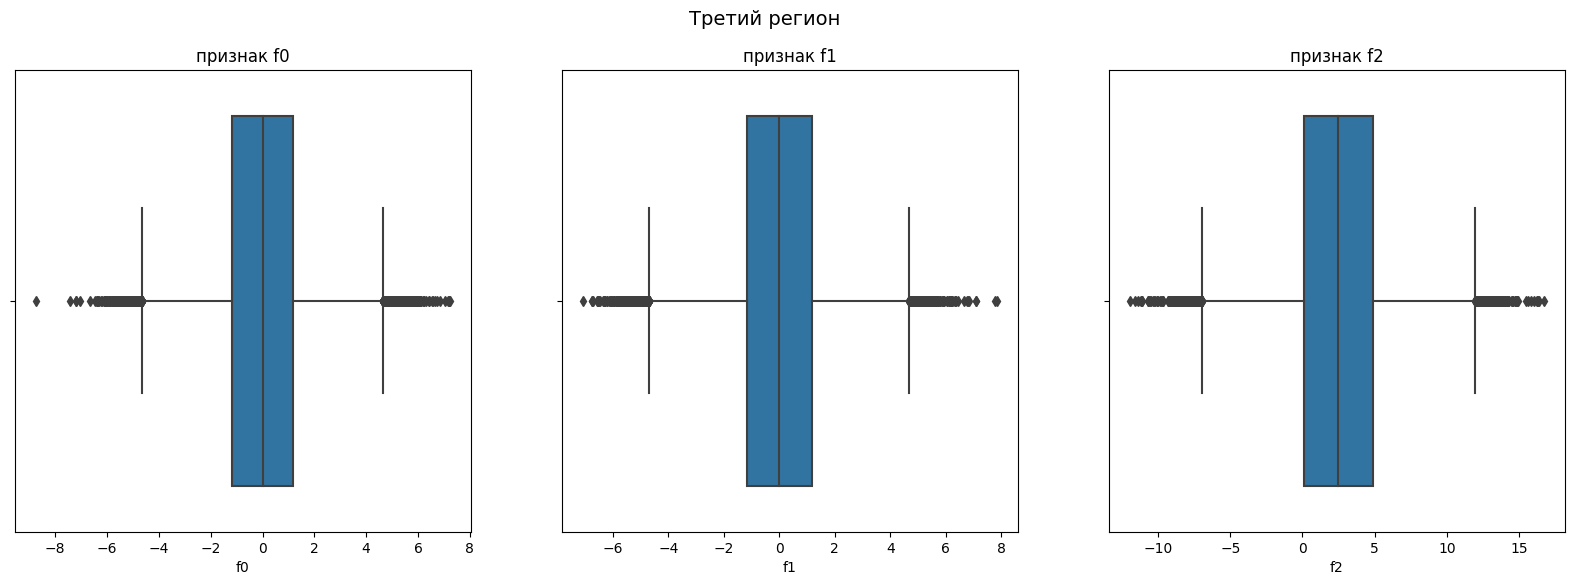

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,6))
fig.suptitle('Первый регион', fontsize=14)
sns.boxplot(x=geo_0['f0'], ax=axes[0]).set_title('признак f0')
sns.boxplot(x=geo_0['f1'], ax=axes[1]).set_title('признак f1')
sns.boxplot(x=geo_0['f2'], ax=axes[2]).set_title('признак f2')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,6))
fig.suptitle('Второй регион', fontsize=14)
sns.boxplot(x=geo_1['f0'], ax=axes[0]).set_title('признак f0')
sns.boxplot(x=geo_1['f1'], ax=axes[1]).set_title('признак f1')
sns.boxplot(x=geo_1['f2'], ax=axes[2]).set_title('признак f2')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,6))
fig.suptitle('Третий регион', fontsize=14)
sns.boxplot(x=geo_2['f0'], ax=axes[0]).set_title('признак f0')
sns.boxplot(x=geo_2['f1'], ax=axes[1]).set_title('признак f1')
sns.boxplot(x=geo_2['f2'], ax=axes[2]).set_title('признак f2');

Выделяется признак f2 для второго региона. Для всех трех регионов большинство значений этого признака лежат в интервале от 0 до 5. При этом второй регион не имеет выбросов и все его значения лежат в этом интервале.

Остальные признаки довольно сильно отличаются для каждого региона.

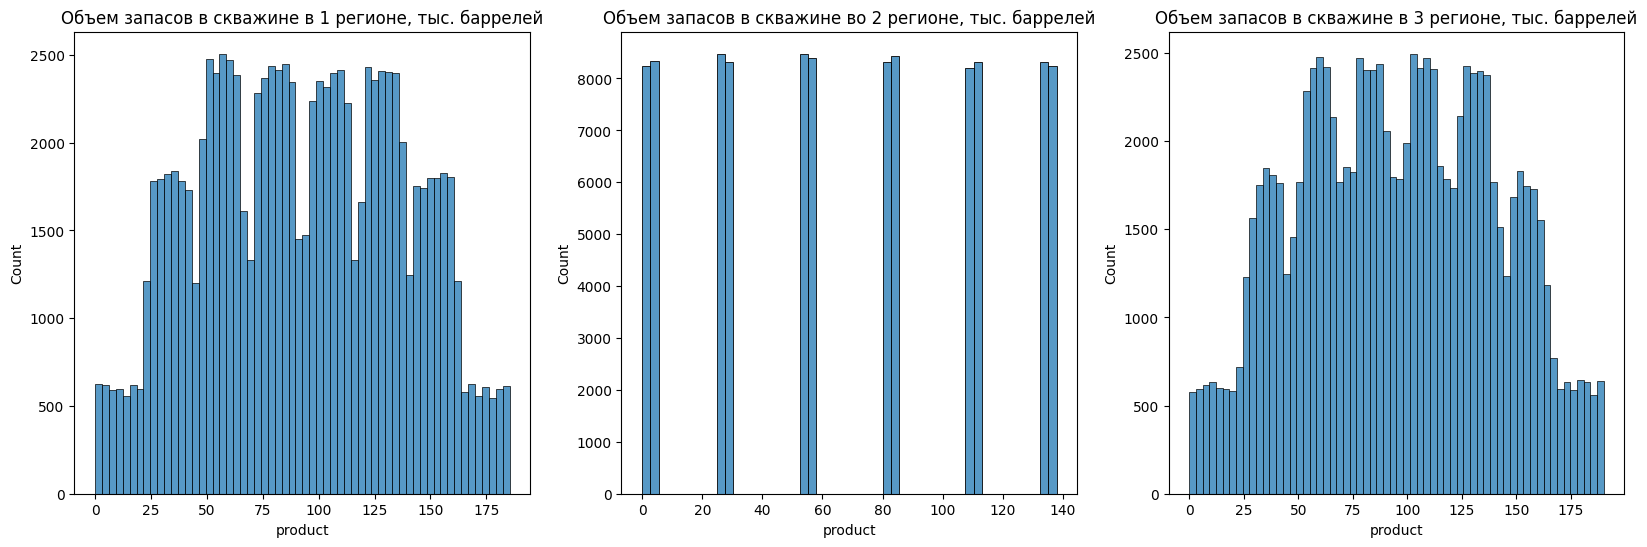

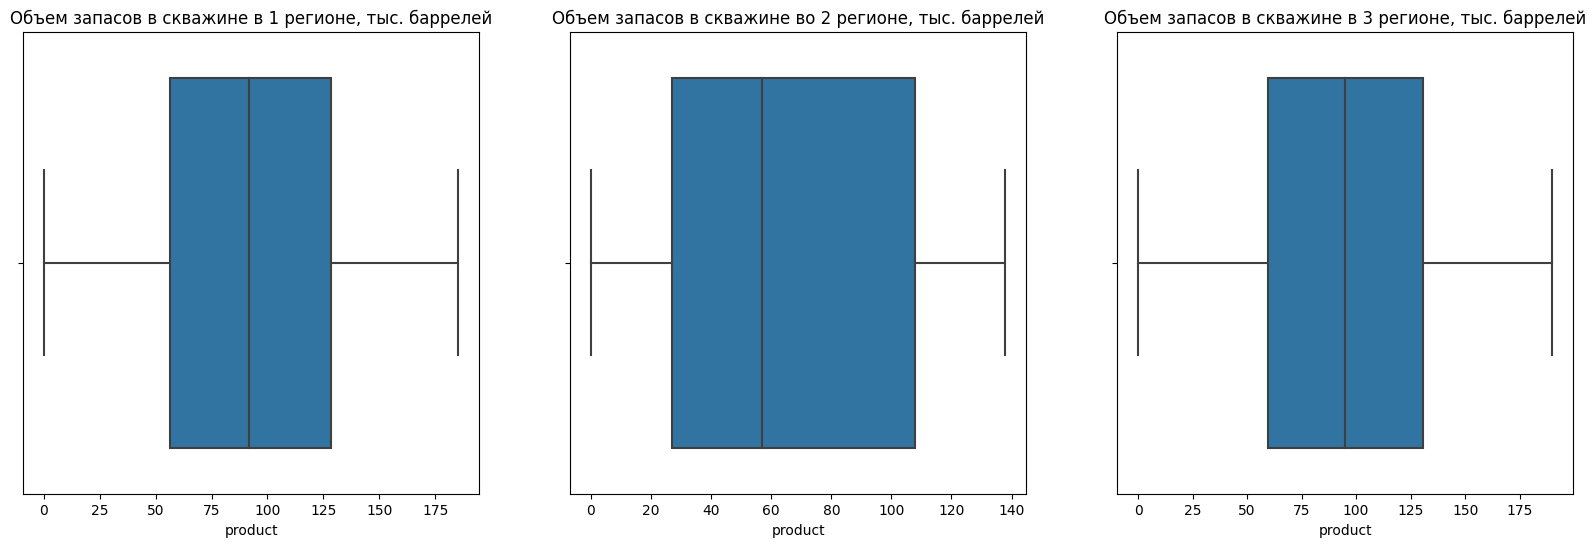

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,6))
sns.histplot(geo_0['product'], ax=axes[0]).set_title(
    'Объем запасов в скважине в 1 регионе, тыс. баррелей')
sns.histplot(geo_1['product'], bins=50, ax=axes[1]).set_title(
    'Объем запасов в скважине во 2 регионе, тыс. баррелей')
sns.histplot(geo_2['product'], ax=axes[2]).set_title(
    'Объем запасов в скважине в 3 регионе, тыс. баррелей');

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,6))
sns.boxplot(x=geo_0['product'], ax=axes[0]).set_title(
    'Объем запасов в скважине в 1 регионе, тыс. баррелей')
sns.boxplot(x=geo_1['product'], ax=axes[1]).set_title(
    'Объем запасов в скважине во 2 регионе, тыс. баррелей')
sns.boxplot(x=geo_2['product'], ax=axes[2]).set_title(
    'Объем запасов в скважине в 3 регионе, тыс. баррелей');

В среднем во втором регионе скважины имеют меньшие объемы запасов чем в двух других регионах.

In [12]:
geo_1['product'].value_counts()

53.906522     8472
26.953261     8468
84.038886     8431
57.085625     8390
3.179103      8337
80.859783     8320
30.132364     8306
134.766305    8304
110.992147    8303
0.000000      8235
137.945408    8233
107.813044    8201
Name: product, dtype: int64

Второй регион имеет интересную тенденцию. С равной вероятностью можно как найти пустое месторождение, так и месторождение со 137 тыс. баррелей нефти.

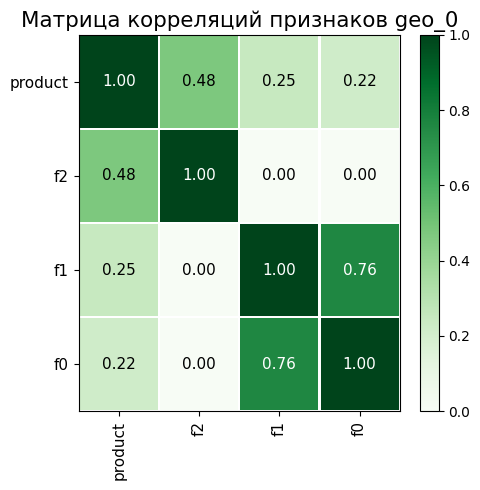

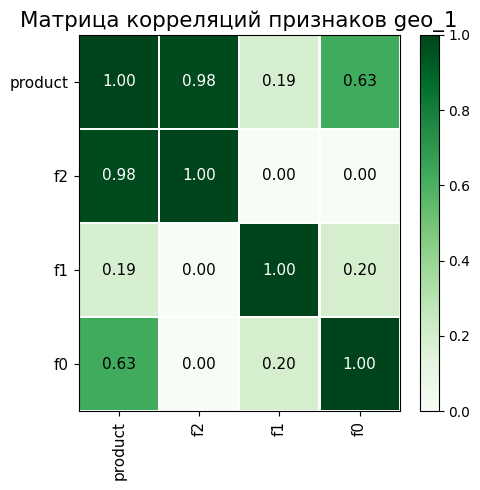

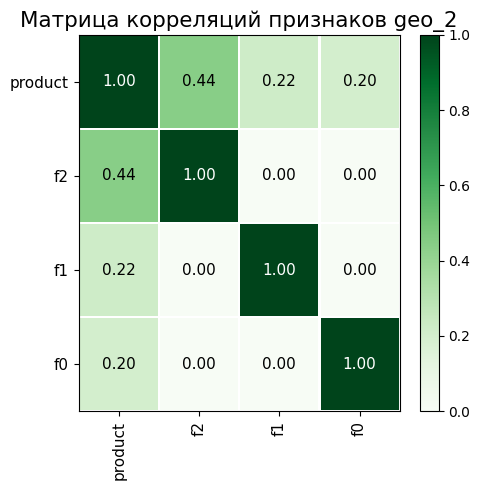

In [13]:
phik_overview=geo_0.phik_matrix(interval_cols=['f0', 'f1', 'f2', 'product'])
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title='Матрица корреляций признаков geo_0',
    fontsize_factor=1.1,
    figsize=(5, 5));

phik_overview=geo_1.phik_matrix(interval_cols=['f0', 'f1', 'f2', 'product'])
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title='Матрица корреляций признаков geo_1',
    fontsize_factor=1.1,
    figsize=(5, 5));

phik_overview=geo_2.phik_matrix(interval_cols=['f0', 'f1', 'f2', 'product'])
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title='Матрица корреляций признаков geo_2',
    fontsize_factor=1.1,
    figsize=(5, 5));

Во втором регионе количество нефти имеет сильную связь с `f0` и `f2`. В первом и третьем регионах целевой признак имеет слабую связь со всеми входными признаками.

На данный момент второй регион выглядит предпочтительнее. Первый и третий регионы слишком идеальные, найти пустое месторождение в них будет очень сложно. Проверим что покажет прогноз модели.

## Обучение и проверка модели

Обучим и проверим модель для каждого региона, для этого разобьем данные на обучающую и валидационную выборки в соотношении 75:25. Для обучения будем использовать модель линейной регрессии. Проверять качество модели будем с помощью метрики RMSE.

In [14]:
model = LinearRegression()

def modeling(x,y):
    X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size = TEST_SIZE, random_state = RANDOM_STATE)
    model.fit(X_train, y_train) 
    y_test_pred = model.predict(X_test)
    y_test_pred = pd.Series(y_test_pred, index=y_test.index)
    mean = y_test_pred.mean()
    print(f'Метрика RMSE на валидационной выборке: {mean_squared_error(y_test, y_test_pred, squared=False)}')
    print(f'Средний запас сырья: {mean}')
    return y_test, y_test_pred

### Первый регион

In [15]:
y_test0, y_test_pred0 = modeling(geo_0.drop(['product'], axis=1), geo_0['product'])

Метрика RMSE на валидационной выборке: 37.75660035026169
Средний запас сырья: 92.39879990657768


### Второй регион

In [16]:
y_test1, y_test_pred1 = modeling(geo_1.drop(['product'], axis=1), geo_1['product'])

Метрика RMSE на валидационной выборке: 0.8902801001028854
Средний запас сырья: 68.71287803913762


### Третий регион

In [17]:
y_test2, y_test_pred2 = modeling(geo_2.drop(['product'], axis=1), geo_2['product'])

Метрика RMSE на валидационной выборке: 40.145872311342174
Средний запас сырья: 94.77102387765939


### Вывод

Второй регион имеет лучшее значение метрики, модель ошибается всего на 1тыс. баррелей, хотя средний запас сырья при этом меньше всех 68тыс. баррелей.

Первый и третий регионы имеют очень плохие метрики, они ошибаются на 37тыс. и 40тыс. баррелей. И даже при большем прогнозе среднего запаса сырья 92тыс. и 94тыс. баррелей, с такими метриками они выглядят хуже.

На данный момент второй регион является лучшим, проверим значения прибыли, чтобы сделать окончательный вердикт.

## Подготовка к расчёту прибыли

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины:

In [18]:
BUDGET = 10_000_000_000 #бюджет
PROFIT = 450_000 #прибыль с 1тыс. баррелей
N = 500 #выбор рандомных n точек
K = 200 #выбор k лучших из них

In [19]:
price = BUDGET / (K * PROFIT)
print('Минимально необходимый объем сырья для одной скважины:', round(price,2))

Минимально необходимый объем сырья для одной скважины: 111.11


In [20]:
profit_mean = BUDGET / PROFIT
print('Суммарный объем сырья для 200 лучших месторождений:', round(profit_mean,2))

Суммарный объем сырья для 200 лучших месторождений: 22222.22


Сравним полученный объём сырья со средним запасом в каждом регионе: 

In [21]:
print('Средний запас сырья в скважине в первом регионе:', round(y_test_pred0.sort_values(ascending=False).head(200).mean(),2))
print('Средний запас сырья в скважине во втором регионе:', round(y_test_pred1.sort_values(ascending=False).head(200).mean(),2))
print('Средний запас сырья в скважине в третьем регионе:', round(y_test_pred2.sort_values(ascending=False).head(200).mean(),2))

Средний запас сырья в скважине в первом регионе: 154.41
Средний запас сырья в скважине во втором регионе: 138.74
Средний запас сырья в скважине в третьем регионе: 148.64


Первый регион в среднем будет предоставлять больше объема сырья, второй является самым худшим выбором из трех.

Тем не менее все три региона имеют достаточный объём сырья для безубыточной разработки новой скважины.

Выберим скважины с максимальными значениями предсказаний и просуммируем целевое значение объёма сырья:

In [22]:
sum_value0 = round(y_test_pred0.sort_values(ascending=False).head(200).sum(),2)
sum_value1 = round(y_test_pred1.sort_values(ascending=False).head(200).sum(),2)
sum_value2 = round(y_test_pred2.sort_values(ascending=False).head(200).sum(),2)
print('Суммарный объем сырья для 200 лучших скважин в первом регионе:', sum_value0)
print('Суммарный объем сырья для 200 лучших скважин во втором регионе:', sum_value1)
print('Суммарный объем сырья для 200 лучших скважин в третьем регионе:', sum_value2)

Суммарный объем сырья для 200 лучших скважин в первом регионе: 30881.46
Суммарный объем сырья для 200 лучших скважин во втором регионе: 27748.75
Суммарный объем сырья для 200 лучших скважин в третьем регионе: 29728.85


Рассчитаем прибыль для полученного объёма сырья:

In [23]:
print('Прибыль от первого региона:', (PROFIT * sum_value0  - BUDGET)/1000000000, 'млрд.р.')
print('Прибыль от второго региона:', (PROFIT * sum_value1 - BUDGET)/1000000000, 'млрд.р.')
print('Прибыль от третьего региона:', (PROFIT * sum_value2 - BUDGET)/1000000000, 'млрд.р.')

Прибыль от первого региона: 3.896657 млрд.р.
Прибыль от второго региона: 2.4869375 млрд.р.
Прибыль от третьего региона: 3.3779825 млрд.р.


При идеальных условиях для 200 лучших скважин из всех трех регионов мы сможем получить прибыль. При этом из второго региона мы получим меньшую прибыль.

Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели

In [24]:
def revenue(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    return PROFIT * selected.sum() - BUDGET

## Расчёт прибыли и рисков 

Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли. Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков.

In [25]:
def bootstrap(y_test, y_pred):
    state = np.random.RandomState(RANDOM_STATE)
    values = []
    for i in range(1000):
        target_subsample = y_test.sample(n=N, replace=True, random_state=state)
        probs_subsample = y_pred[target_subsample.index]
        prof = revenue(target_subsample, probs_subsample, K)
        values.append(prof)
    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    risk = (values < 0).mean() * 100
    mean = values.mean()
    print("Средняя выручка:", round(mean/1e6,2),'млн.р.')
    print('Нижнее значение доверительного интервала:', round(lower/1e6,2),'млн.р.')
    print('Верхнее значение доверительного интервала:', round(upper/1e6,2),'млн.р.')
    print('Риск убытков:', round(risk, 2),'%')

In [26]:
bootstrap(y_test0, y_test_pred0)

Средняя выручка: 427.85 млн.р.
Нижнее значение доверительного интервала: -97.25 млн.р.
Верхнее значение доверительного интервала: 954.22 млн.р.
Риск убытков: 5.5 %


In [27]:
bootstrap(y_test1, y_test_pred1)

Средняя выручка: 511.36 млн.р.
Нижнее значение доверительного интервала: 98.87 млн.р.
Верхнее значение доверительного интервала: 940.72 млн.р.
Риск убытков: 0.9 %


In [28]:
bootstrap(y_test2, y_test_pred2)

Средняя выручка: 402.58 млн.р.
Нижнее значение доверительного интервала: -137.16 млн.р.
Верхнее значение доверительного интервала: 929.89 млн.р.
Риск убытков: 7.4 %


Первый и третий регион имеют высокий риск убытков, при этом величина убытков имеет значения в районе 100 миллионов рублей.

Второй регион с 95% вероятностью будет иметь минимум 98 миллионов рублей прибыли. При этом риск убытков составляет всего 0.9%.
Среднее значение прибыли для второго региона составит 511 миллионов рублей.

Исходя из полученных результатов можно смело рекомендовать второй регион для бурления там новых скважин.

## Итоговый вывод

Нам были предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Мы определили регион для бурления новой скважины. 
Для этого мы построили модель машинного обучения, которая помогла определить регион, где добыча принесёт наибольшую прибыль.
А также проанализировали возможную прибыль и риски техникой Bootstrap.

В ходе обработки данных мы:

- Убедились в отсутствии пропущенных значений и корректности типов данных,
- Перевели значения из столбцов id в индексы,
- Убедились в отсутствии дублирующих позиций.

В ходе анализа данных мы получили, что:

- Определили количество нулевых значений в столбце `product`, для первого и третьего региона по 1 скважине имеет нулевое значение, второй регион имеет 8235 нулевых значений,
- Признак f2 для второго региона имеет значения, лежащие около чисел 0,1,2,3,4,5. Для второго и третьего регионов признак f2 имеет нормальное распределение, большинство значений лежат также в интервале от 0 до 5,
- Признаки f0 и f1 отличаются своими значениями для каждого региона,
- В среднем во втором регионе скважины имеют меньшие объемы запасов чем в двух других регионах.
- Во втором регионе количество нефти имеет сильную связь с f0 и f2. В первом и третьем регионах целевой признак имеет слабую связь со всеми входными признаками.


Для обучения модели использовали линейную регрессию. Входные признаки `f0,f1,f2`, целевой признак `product`.
Данные разбивали на обучающую и валидационную выборки в соотношении 75:25. Проверяли качество модели с помощью метрики RMSE.

- Первый регион, метрика RMSE на валидационной выборке: 37.75, средний запас сырья: 92.40
- Второй регион, метрика RMSE на валидационной выборке: 0.89, средний запас сырья: 68.71
- Третий регион, метрика RMSE на валидационной выборке: 40.14, средний запас сырья: 94.77

Второй регион имеет лучшее значение метрики, но в то же время худший средний запас сырья.

Бюджет на разработку скважин в регионе — 10 млрд рублей. Доход с каждой единицы продукта (тысяч баррелей) составляет 450 тыс. рублей.

В ходе подготовки к расчету прибыли мы:

- Рассчитали достаточный объём сырья для безубыточной разработки новой скважины: 111.11 тысяч баррелей,
- Опредили суммарный объем сырья для 200 лучших месторождений для безубыточной разработки: 22222.22 тысяч баррелей,
- Написали функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели.

Все три региона имеют достаточный объём сырья для безубыточной разработки новой скважины:

- Средний запас сырья в скважине в первом регионе: 154.41 тысяч баррелей,
- Средний запас сырья в скважине во втором регионе: 138.74 тысяч баррелей,
- Средний запас сырья в скважине в третьем регионе: 148.64 тысяч баррелей.

Так же мы рассчитали идеальные условия, выбрав по 200 лучших месторождений из каждого региона:
- Суммарный объем сырья в первом регионе: 30881.46 тысяч баррелей, Прибыль: 3.90 млрд.р.;
- Суммарный объем сырья во втором регионе: 27748.75 тысяч баррелей, Прибыль: 2.50 млрд.р.;
- Суммарный объем сырья в третьем регионе: 29728.85 тысяч баррелей, Прибыль: 3.38 млрд.р.

При идеальных условиях для 200 лучших скважин из всех трех регионов мы сможем получить прибыль. При этом из второго региона мы получим меньшую прибыль.

Для расчёта прибыли и рисков мы применяли технику Bootstrap с 1000 выборок. Для разведки региона мы использовали 500 точек, из которых с помощью машинного обучения выбирали 200 лучших для разработки.
В ходе решения мы получили:

- Для первого региона: Средняя прибыль: 427.85 млн.р., 95%-й доверительный интервал (-97.25 млн.р., 954.22 млн.р.), Риск убытков 5.5 %
- Для второго региона: Средняя прибыль: 511.36 млн.р., 95%-й доверительный интервал (98.87 млн.р., 940.72 млн.р.), Риск убытков 0.9 %
- Для третьего региона: Средняя прибыль: 402.58 млн.р., 95%-й доверительный интервал (-137.16 млн.р., 929.89 млн.р.), Риск убытков 7.4 %

Первый и третий регион имеют высокий риск убытков, при этом величина убытков может составлять 100 миллионов рублей.

Второй регион с 95% вероятностью будет иметь минимум 98 миллионов рублей прибыли. При этом риск убытков составляет всего 0.9%. Среднее значение прибыли для второго региона составит 511 миллионов рублей.

Исходя из полученных результатов можно смело рекомендовать второй регион для бурления там новых скважин.

Для дополнительных рекомендаций можно узнать что именно означают признаки f0, f1, f2, чтобы лучше понимать их влияние на выбор региона. Так же можно увеличить количество признаков, добавив например химический состав почвы в месторождениях.